In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import mean_squared_error

from data.city.load_cities import CITY
from data.prediction.methods.mean_predictor import PredictByMean
from data.prediction.methods.XGBoost import PredictByXGBoost

C:\Users\theo3\AppData\Local\Temp\ipykernel_18388\2424356003.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [26]:
TRAIN_SIZE = 0.7
method = PredictByMean(city=CITY,prediction_length=24*7,train_size=TRAIN_SIZE)
method.train()

station = method.df_dataset.columns[0]
r = method.df_dataset[station].iloc[:168]
method.predict(station, r)

# On calcule la MSE totale pour toutes les stations

mse_values = []
for station in method.df_dataset.columns:
    r = method.df_dataset[station].iloc[:168]
    prediction = method.predict(station, r)
    mse = mean_squared_error(r, prediction)
    mse_values.append(mse)
    
print(f"MSE: {np.mean(mse_values)}")

MSE: 0.062063411374164254


In [7]:
model = PredictByMean(city=CITY,prediction_length=24*7,train_size=TRAIN_SIZE)
model.train()

start_week = 168 * 3
station = 1

df_predict: pd.DataFrame = model.predict(data=CITY.df_hours.columns[station]).reset_index(drop=True)
df_predict[CITY.df_hours.columns[station] + '-obs'] = CITY.df_hours[CITY.df_hours.columns[station]].iloc[start_week:start_week + len(df_predict)].reset_index(drop=True)
df_predict.index = CITY.df_hours['date'].iloc[start_week:start_week + len(df_predict)]

print('MSE:', mean_squared_error(df_predict[df_predict.columns[1]], df_predict[df_predict.columns[0]]))

fig = px.line(
    data_frame=df_predict
)

fig.update_layout(hovermode='x')

fig.show()

TypeError: PredictByMean.predict() missing 1 required positional argument: 'selected_stations'

In [2]:
TRAIN_SIZE = 0.7
PREDICTION_LENGTH = 24*7  # Prédiction sur une semaine
method = PredictByXGBoost(city=CITY, prediction_length=PREDICTION_LENGTH, train_size=TRAIN_SIZE)
method.train()

C:\Users\theo3\AppData\Local\Temp\ipykernel_18388\1467362896.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index = pd.date_range(start=start, end=end, freq='H')


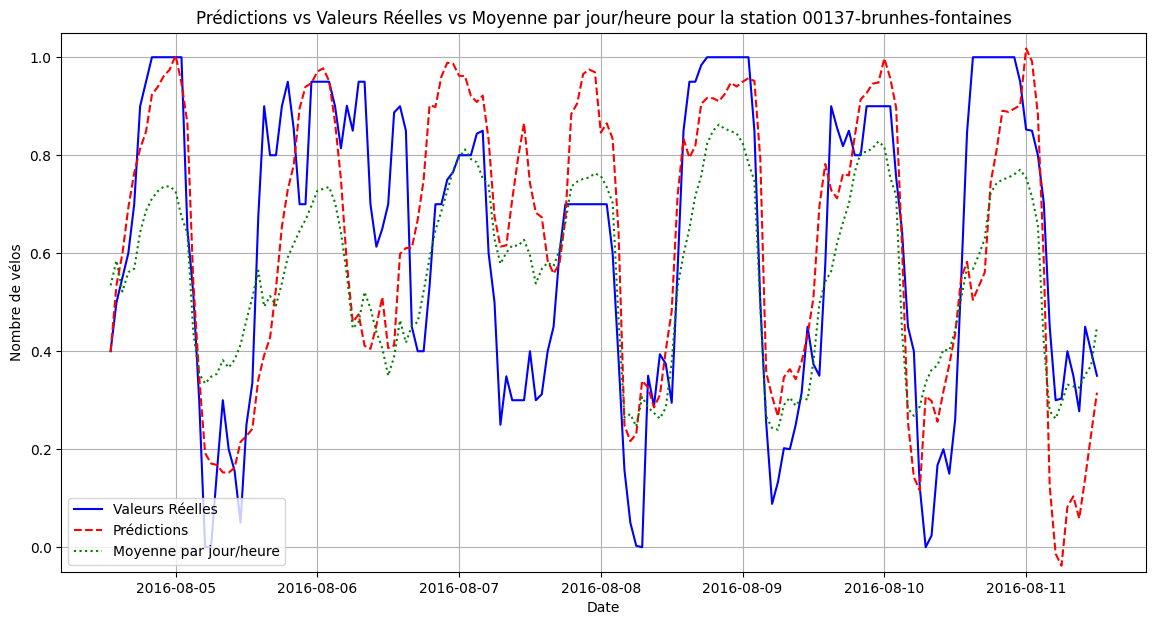

MSE pour les prédictions sur la station 00137-brunhes-fontaines: 0.04648962982451124


In [5]:
station = method.df_dataset.columns[78]  # Changer la station ici
last_train_date = method.train_dataset.index[-1]  

start_prediction = last_train_date + pd.DateOffset(hours=1)  
end_prediction = start_prediction + pd.DateOffset(hours=PREDICTION_LENGTH - 1)  
real_data = method.df_dataset.loc[start_prediction:end_prediction, station]

predictions = method.predict(station)

df_mean = method.df_dataset.copy()
df_mean = df_mean.loc[:last_train_date]
df_mean['hour'] = df_mean.index.hour
df_mean['day_of_week'] = df_mean.index.dayofweek
hourly_weekday_mean = df_mean.groupby(['day_of_week', 'hour'])[station].mean().unstack()

def get_hourly_weekday_means(start, end):
    index = pd.date_range(start=start, end=end, freq='H')
    mean_values = [hourly_weekday_mean.loc[date.dayofweek, date.hour] for date in index]
    return pd.Series(data=mean_values, index=index)

predicted_means = get_hourly_weekday_means(start_prediction, end_prediction)

plt.figure(figsize=(14, 7))
plt.plot(real_data.index, real_data.values, label='Valeurs Réelles', color='blue')
plt.plot(predictions.index, predictions.values, label='Prédictions', color='red', linestyle='--')
plt.plot(predicted_means.index, predicted_means.values, label='Moyenne par jour/heure', color='green', linestyle=':')
plt.title(f'Prédictions vs Valeurs Réelles vs Moyenne par jour/heure pour la station {station}')
plt.xlabel('Date')
plt.ylabel('Nombre de vélos')
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True)
plt.show()


# Calculer la Mean Squared Error
mse = mean_squared_error(real_data.values, predictions.values)
print(f'MSE pour les prédictions sur la station {station}: {mse}')


In [4]:
# On calcule la MSE totale pour toutes les stations
mse_values = []

for station in method.df_dataset.columns:
    real_data = method.df_dataset.loc[start_prediction:end_prediction, station]
    predictions = method.predict(station)

    mse = mean_squared_error(real_data.values, predictions.values)
    mse_values.append(mse)
    
total_mse = np.mean(mse_values)
print(f'MSE totale pour les prédictions sur toutes les stations: {total_mse}')

MSE totale pour les prédictions sur toutes les stations: 0.07848809000769846


In [ ]:
DATE_RANGE = ('04-01-2016', '10-31-2016')

df = pd.read_csv(
    f'./data/city/Toulouse/X_hour_toulouse.csv',
    index_col=0
)
df['date'] = pd.date_range(*DATE_RANGE, freq='1h')[:len(df)]
df.set_index('date', inplace=True)

In [ ]:
a = pd.Series([False, True, True, False, True], index=[0, 1, 2, 9, 10])
a[0]

False

In [ ]:
def get_interpolated_indices(serie: pd.Series, tolerance: float=1e-3, output_type: str='mask'):

    mask, current_mask = [], []
    for index in range(len(serie)):
        # Si < 2 éléments d'affilé de suite
        if len(current_mask) < 2:
            current_mask.append(serie.index.values[index])
            continue
        
        # On check si la différence est la même entre trois éléments d'affilé de suite
        if np.abs((serie.values[index - 2] - serie.values[index - 1]) - (serie.values[index - 1] - serie.values[index])) < tolerance:
            current_mask.append(serie.index.values[index])
            continue
        
        # Si la différence est constante et la longueur de l'interpolation < 24 heures
        if len(current_mask) < 24 and np.abs(serie.values[index - 2] - serie.values[index - 1]) < tolerance:
            current_mask = []

        if len(current_mask) > 2:
            mask.append(current_mask[1:-1])
        current_mask = [serie.index.values[index - 1], serie.index.values[index]]

    if output_type == 'mask':
        return serie[[index_mask for row in mask for index_mask in row]].index

    if output_type == 'list':
        return mask
    
    raise ValueError('The "output_type" value must be one of the following : "mask", "list".')

In [ ]:
index_column = 0
tmp = df.loc[:].iloc[:, index_column].copy()
# tmp = pd.Series([-2, 1, 2, 3, 84, 56, 98, 5, 4, 3, 2, 92])

index = get_interpolated_indices(tmp, output_type='list')
print(len(index))
index = [u for v in index for u in v]
tmp.loc[index] = np.nan

a = tmp.to_frame()
a['origine'] = df.iloc[:, index_column].copy()
fig = px.line(a).show()

NameError: name 'df' is not defined